In [3]:
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'keras_tuner'

In [3]:
# load mnist dataset
(x_train, _), (x_test, _) = mnist.load_data()
# normalize data
x_train, x_test = x_train / 255.0, x_test / 255.0

# split the training set into training and validation sets
x_train, x_valid, train_ground, valid_ground = train_test_split(x_train, x_train, test_size=0.2, random_state=13)
# x_train: used for actual training.
# x_valid: used for validation after each epoch.
# train_ground, valid_ground: They represent what the output of the autoencoder should ideally look like.
#                             Since an autoencoder tries to reconstruct its input, both train_ground and valid_ground
#                             are the same as x_train and x_valid.

In [4]:
class AutoencoderHyperModel(HyperModel):

    def build(self, hp):
        model = Sequential()
        # Encoder
        model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32 ) ,
                         (3,2) ,
                         activation='relu', padding='same', input_shape=(28, 28, 1)))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32 ) ,
                         (3,3) ,
                         activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32 ) ,
                         (3,3), 
                         activation='relu', padding='same'))
        model.add(Flatten())
        model.add(Dense(hp.Choice('latent_space_neurons', values=[10,20,30]), activation='relu'))
        # Decoder
        model.add(Dense(49, activation='relu')) 
        model.add(Reshape((7, 7, 1)))
        model.add(Conv2DTranspose(hp.Int('input_units', min_value=32, max_value=256, step=32 ),
                                  (3,3 ),
                                  activation='relu', padding='same'))
        model.add(UpSampling2D((2, 2)))
        model.add(Conv2DTranspose(hp.Int('input_units', min_value=32, max_value=256, step=32 ),
                                  (3, 3), 
                                  activation='relu', padding='same'))
        model.add(UpSampling2D((2, 2)))
        model.add(Conv2DTranspose(1,(3,3), activation='sigmoid', padding='same'))

        model.compile(optimizer=RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mean_squared_error')

        return model

hypermodel = AutoencoderHyperModel()
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='tuner_mnist'
)

Reloading Tuner from my_dir/tuner_mnist/tuner0.json


In [ ]:
tuner.search(x_train, train_ground, epochs=10, validation_data=(x_valid, valid_ground))

In [5]:
tuner.results_summary()


Results summary
Results in my_dir/tuner_mnist
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
input_units: 224
latent_space_neurons: 30
learning_rate: 0.001
Score: 0.006683835526928306

Trial 06 summary
Hyperparameters:
input_units: 256
latent_space_neurons: 30
learning_rate: 0.001
Score: 0.0072817676700651646

Trial 01 summary
Hyperparameters:
input_units: 64
latent_space_neurons: 30
learning_rate: 0.001
Score: 0.008625002577900887

Trial 03 summary
Hyperparameters:
input_units: 96
latent_space_neurons: 20
learning_rate: 0.001
Score: 0.009397622663527727

Trial 04 summary
Hyperparameters:
input_units: 64
latent_space_neurons: 30
learning_rate: 0.01
Score: 0.011539270635694265

Trial 05 summary
Hyperparameters:
input_units: 192
latent_space_neurons: 30
learning_rate: 0.0001
Score: 0.01385280629619956

Trial 02 summary
Hyperparameters:
input_units: 96
latent_space_neurons: 10
learning_rate: 0.0001
Score: 0.02842608280479908

Trial 08

In [6]:
# get the best model and print its summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 224)       1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 224)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 224)       451808    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 224)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 224)         451808    
                                                                 
 flatten (Flatten)           (None, 10976)             0

2024-01-10 18:37:37.640739: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

{'input_units': 224, 'latent_space_neurons': 30, 'learning_rate': 0.001}


In [8]:
# save the model 
best_model.save('best_model.h5')


In [9]:
best_model.evaluate(x_test, x_test)

313/313 [==============================] - 20s 62ms/step - loss: 0.0065


0.0064978948794305325

1/1 [==============================] - 0s 32ms/step


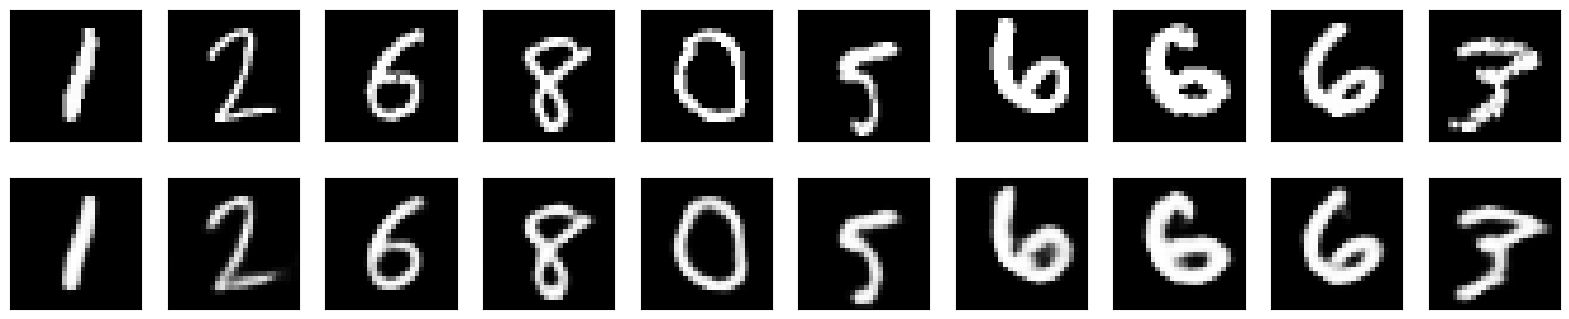

In [20]:
# load the model
# best_model = load_model('best_model.h5') # uncomment this line if you want to load the model without running the tuner

# display some images and their reconstructions

start = 455             # put any index from the query set
end = start + 10        # by default, display 10 images

decoded_images = best_model.predict(x_test[start:end])

plt.figure(figsize=(20, 4))
for i in range(end-start):
    # Display original
    ax = plt.subplot(2, end-start, i + 1)
    plt.imshow(x_test[i+start].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, end-start, i + 1 + end-start)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()